In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [3]:
# Load the dataset
df = pd.read_csv('/kaggle/input/diabetes/diabetes.csv')

In [5]:
# Display the first few rows of the dataset
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


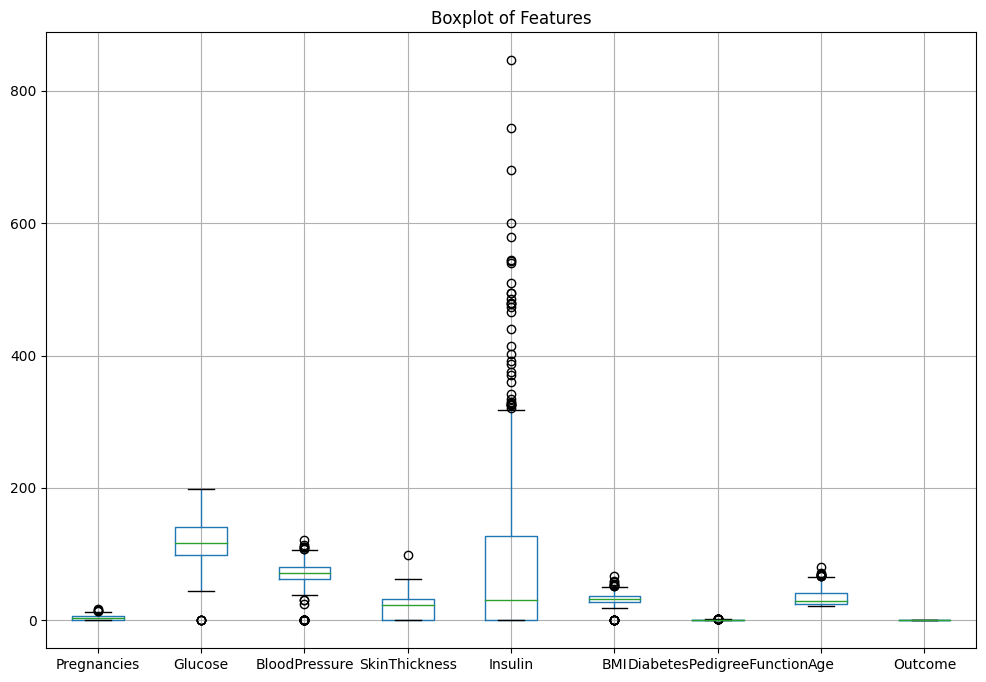

In [7]:
# Check for outliers using boxplots
plt.figure(figsize=(12, 8))
df.boxplot()
plt.title('Boxplot of Features')
plt.show()

In [8]:
# Handle outliers using Winsorization (cap values at the 5th and 95th percentiles)
from scipy.stats.mstats import winsorize
df['Insulin'] = winsorize(df['Insulin'], limits=[0.05, 0.05])
df['SkinThickness'] = winsorize(df['SkinThickness'], limits=[0.05, 0.05])

In [9]:
# Feature Engineering: Create BMI categories
df['BMI_Category'] = pd.cut(df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# Feature Engineering: Create Age groups
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 30, 50, 100], labels=['Young', 'Middle-aged', 'Elderly'])

# Convert categorical features to dummy variables
df = pd.get_dummies(df, columns=['BMI_Category', 'Age_Group'], drop_first=True)

In [10]:
# Check class imbalance
df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [11]:
# Handle class imbalance using SMOTE
X = df.drop('Outcome', axis=1)
y = df['Outcome']
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [13]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
# Feature selection using SelectKBest
selector = SelectKBest(score_func=f_classif, k=7)  # Select top 10 features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

In [24]:
# Load the SVM model
svm_model = SVC(random_state=42)

In [25]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [2,3,4]
}
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_selected, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='accuracy')

In [26]:
 #Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(f"Best Parameters: {best_params}")

Best Parameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}


In [27]:
# Evaluate the model on the training set
y_train_pred = best_model.predict(X_train_selected)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

Training Accuracy: 80.25%


In [28]:
# Evaluate the model on the test set
y_pred = best_model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 79.00%


In [30]:
# Classification report and confusion matrix for training set
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Training Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))

Training Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       401
           1       0.80      0.81      0.80       399

    accuracy                           0.80       800
   macro avg       0.80      0.80      0.80       800
weighted avg       0.80      0.80      0.80       800

Training Confusion Matrix:
[[320  81]
 [ 77 322]]


In [31]:
# Classification report and confusion matrix for test set
print("Test Classification Report:")
print(classification_report(y_test, y_pred))

print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Test Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        99
           1       0.79      0.79      0.79       101

    accuracy                           0.79       200
   macro avg       0.79      0.79      0.79       200
weighted avg       0.79      0.79      0.79       200

Test Confusion Matrix:
[[78 21]
 [21 80]]


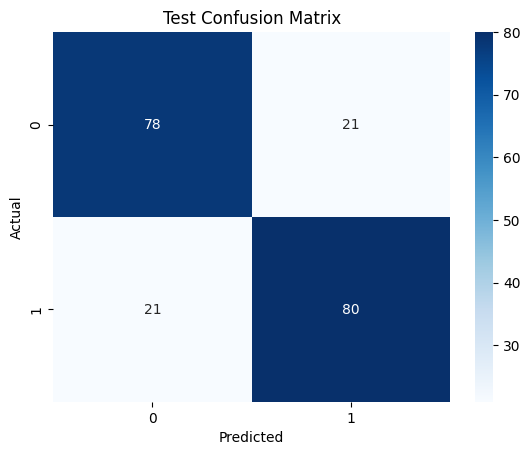

In [32]:
# Plot confusion matrix for test set
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [35]:
# Cross-validation to ensure model generalization
cv_scores = cross_val_score(best_model, X_train_selected, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {np.mean(cv_scores) * 100:.2f}%")

Cross-Validation Accuracy: 80.00%
